## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [3]:
#from get_data import unpack
#unpack('data.rar')

In [4]:
#!unzip data.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: data/images/01000.jpg   
  inflating: data/images/01001.jpg   
  inflating: data/images/01002.jpg   
  inflating: data/images/01003.jpg   
  inflating: data/images/01004.jpg   
  inflating: data/images/01005.jpg   
  inflating: data/images/01006.jpg   
  inflating: data/images/01007.jpg   
  inflating: data/images/01008.jpg   
  inflating: data/images/01009.jpg   
  inflating: data/images/01010.jpg   
  inflating: data/images/01011.jpg   
  inflating: data/images/01012.jpg   
  inflating: data/images/01013.jpg   
  inflating: data/images/01014.jpg   
  inflating: data/images/01015.jpg   
  inflating: data/images/01016.jpg   
  inflating: data/images/01017.jpg   
  inflating: data/images/01018.jpg   
  inflating: data/images/01019.jpg   
  inflating: data/images/01020.jpg   
  inflating: data/images/01021.jpg   
  inflating: data/images/01022.jpg   
  inflating: data/images/01023.jpg   
  inflating: data/images/01024.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
### Useful routines for preparing data
from numpy import array, zeros
import numpy as np
from os.path import join
import os
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd

def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    imgs = []
    points_x = []
    points_y = []
    points = []
    df = pd.read_csv(os.path.join(dirname, 'gt.csv'))
    colums = df.columns[df.columns != 'filname']
    col_x = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14']
    col_y = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14']
    for i in os.listdir(os.path.join(dirname, 'images')):
  #  print(i)
        tmp = gray2rgb(imread(os.path.join(dirname,'images',i)))
        points_x.append(np.squeeze(df.loc[df.filename == i, col_x].values/tmp.shape[0] - 0.5))
        points_y.append(np.squeeze(df.loc[df.filename == i, col_y].values/tmp.shape[1] - 0.5))
        imgs.append(resize(tmp, [100, 100], mode = 'constant'))
    for l_x, l_y in zip(points_x, points_y):
        tmp = []
        for x, y in zip(l_x, l_y):
            tmp.append(x)
            tmp.append(y)
        points.append(tmp)
    return np.stack(imgs), points
    pass

imgs, points = load_imgs_and_keypoints()

F:\Anaconda\Anaconda\envs\tf-gpu-2\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


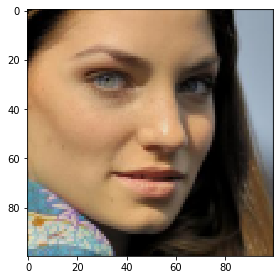

In [2]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
#points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

22.340425531914892 21.276595744680847
38.297872340425535 19.148936170212767
60.63829787234043 20.21276595744681
85.1063829787234 26.595744680851062
24.468085106382976 28.723404255319153
36.17021276595745 27.659574468085108
42.5531914893617 29.78723404255319
62.76595744680851 31.914893617021278
72.3404255319149 31.914893617021278
82.97872340425532 35.1063829787234
45.744680851063826 48.93617021276596
32.97872340425532 64.8936170212766
47.87234042553192 70.2127659574468
63.829787234042556 69.14893617021278


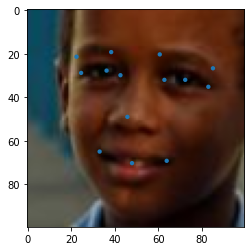

In [3]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for i in range(0, 27, 2):
        x = (points[i] + 0.5) * 100
        y = (points[i + 1] + 0.5) * 100
        print("{} {}".format(x, y))
        ax.add_patch(Circle((x, y), 1))
    plt.show()
    pass
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [4]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

In [5]:
points_val = np.stack(points_val)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

77.65957446808511 21.276595744680847
61.702127659574465 19.148936170212767
39.36170212765957 20.21276595744681
14.893617021276595 26.595744680851062
75.53191489361703 28.723404255319153
63.829787234042556 27.659574468085108
57.446808510638306 29.78723404255319
37.23404255319149 31.914893617021278
27.6595744680851 31.914893617021278
17.021276595744684 35.1063829787234
54.255319148936174 48.93617021276596
67.02127659574468 64.8936170212766
52.127659574468076 70.2127659574468
36.170212765957444 69.14893617021278


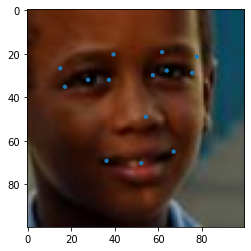

In [6]:
import skimage
def flip_img(img, points):
    # Write your code for flipping here
    f_points = np.array(points)
    f_points[0::2] = -f_points[0::2]
    f_img = np.flip(img, axis = 1)
    return f_img, f_points 
    pass

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [10]:
# Write your code here
# Write your code here
aug_imgs_train = []
aug_points_train = []
for img, point in zip(imgs, points):
    f_img, f_points = flip_img(img, point)
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
aug_imgs_train = np.stack(aug_imgs_train)
#aug_imgs_train = aug_imgs_train.astype(np.float16)
aug_points_train = np.stack(aug_points_train)
#aug_points_train = aug_points_train.astype(np.float16)

86.14457831325302 69.87951807228916
76.50602409638554 50.0
71.6867469879518 34.33734939759036
66.26506024096386 11.445783132530119
78.3132530120482 69.27710843373494
75.90361445783132 57.831325301204814
71.6867469879518 52.40963855421686
64.45783132530121 36.144578313253014
64.45783132530121 24.69879518072289
62.65060240963856 18.67469879518072
45.18072289156626 51.80722891566265
36.14457831325302 73.49397590361446
30.722891566265066 60.24096385542169
27.108433734939762 48.795180722891565


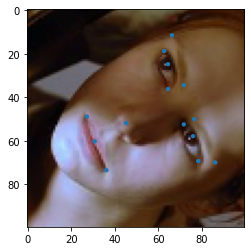

In [11]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

76.61290322580645 14.516129032258062
49.193548387096776 20.161290322580644
32.25806451612904 25.806451612903224
15.322580645161288 27.419354838709676
69.35483870967742 25.0
61.29032258064516 27.419354838709676
52.41935483870967 31.451612903225808
36.29032258064516 35.483870967741936
31.45161290322581 34.67741935483871
23.38709677419355 36.29032258064516
41.93548387096774 57.25806451612904
62.903225806451616 66.93548387096774
49.193548387096776 70.16129032258065
39.516129032258064 71.7741935483871


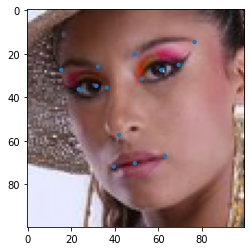

In [12]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [13]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3),  padding = 'same', activation = 'relu', input_shape = (100, 100, 3)))
model.add(MaxPooling2D(pool_size = (2, 2))) 
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(rate = 0.5, input_shape = (100, 100, 3)))
model.add(Dense(128))
model.add(Dropout(rate = 0.5, input_shape = (100, 100, 3)))
model.add(Dense(28))
# Define here your model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [18]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
import keras
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = ['accuracy'])
callback = [
            ModelCheckpoint('best_model.h5',save_best_only=True)
           ]
model.fit(aug_imgs_train, 
          aug_points_train, 
          epochs = 30,
          verbose = 2,
          batch_size = 150,
          validation_data = (imgs_val, points_val),
          callbacks = [ModelCheckpoint('best_model.h5',save_best_only=True)]
          )
# Choose optimizer, compile model and run training

MemoryError: Unable to allocate 687. MiB for an array with shape (6000, 100, 100, 3) and data type float32

In [19]:
history = model.history.history

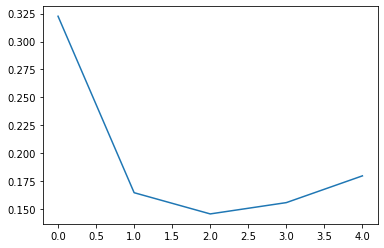

In [17]:
#plt.plot(history['accuracy'])
plt.plot(history['val_loss'])

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [44]:
yhat = model.predict(imgs_val)

70.80617398023605 32.38373249769211
56.29160925745964 27.25299596786499
40.278009325265884 28.981253504753113
24.04024302959442 28.65552306175232
71.13739848136902 33.63624960184097
64.34987038373947 33.88905972242355
53.954824060201645 38.31303045153618
37.74200230836868 35.786014795303345
38.14111575484276 36.517974734306335
33.17513167858124 39.002469182014465
49.35745452530682 52.89188511669636
56.5450519323349 62.003880739212036
48.15577231347561 62.324122339487076
35.801249742507935 68.28693896532059


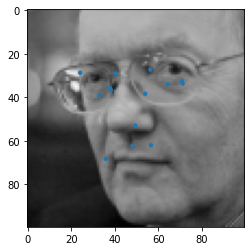

In [45]:
# Example of output
visualize_points(imgs_val[0], yhat[0])